Here, I do 1 `forward` pass and manually compare each intermediate output with the cloud version.

As the first large difference between local and cloud outputs are after 1st resnet, I'll compare the intermediate outputs of that 1st resnet in detail.

In [2]:
import torch
from torch.testing import assert_close
from torch import allclose, nn, tensor
torch.set_printoptions(linewidth=200)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
device_dtype = torch.float16 if device == 'cuda' else torch.float32

## Load the model

In [4]:
from diffusers import StableDiffusionXLPipeline
from diffusers import EulerDiscreteScheduler
from diffusers.models.controlnetxs import ControlNetXSModel
from diffusers.pipelines.controlnet_xs.pipeline_controlnet_xs_sd_xl import StableDiffusionXLControlNetXSPipeline

In [5]:
sdxl_pipe = StableDiffusionXLPipeline.from_single_file('weights/sdxl/sd_xl_base_1.0_0.9vae.safetensors').to(device)
cnxs = ControlNetXSModel.from_pretrained('weights/cnxs').to(device)

At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...
At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...


In [6]:
cnxs.base_model = sdxl_pipe.unet

The example script of Heidelberg manually sets scale_list to 0.95

In [7]:
cnxs.scale_list = cnxs.scale_list * 0. + 0.95
assert cnxs.scale_list[0] == .95

Heidelberg uses `timestep_spacing = 'linspace'` in their scheduler, so let's do that as well

In [8]:
scheduler_cgf = dict(sdxl_pipe.scheduler.config)
scheduler_cgf['timestep_spacing'] = 'linspace'
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

# test it worked
sdxl_pipe.scheduler.set_timesteps(50)
assert sdxl_pipe.scheduler.timesteps[0]==999

# reset
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...
timestep_spacing = "leading" and timesteps=[999.      978.61224 958.2245  937.83673 917.449  ] ...
sigmas before interpolation: [0.02916753 0.04131448 0.05068044 0.05861427 0.06563709] ...
sigmas after (linear) interpolation: [14.61464691 12.93677721 11.49164976 10.24291444  9.16035419] ...
At end of `set_timesteps`:
sigmas =  tensor([14.6146, 12.9368, 11.4916, 10.2429,  9.1604]) ...
timesteps = tensor([999.0000, 978.6122, 958.2245, 937.8367, 917.4490]) ...
At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...


In [9]:
cnxs_pipe = StableDiffusionXLControlNetXSPipeline(
    vae=sdxl_pipe.vae,
    text_encoder=sdxl_pipe.text_encoder,
    text_encoder_2=sdxl_pipe.text_encoder_2,
    tokenizer=sdxl_pipe.tokenizer,
    tokenizer_2=sdxl_pipe.tokenizer_2,
    unet=sdxl_pipe.unet,
    controlnet=cnxs,
    scheduler=sdxl_pipe.scheduler,
)

___

## Load intermediate outputs of full model

These were computed on the cloud with Heidelberg code

In [10]:
from util_inspect import load_intermediate_outputs, print_metadata, compare_intermediate_results

In [ ]:
model_outp_cloud = load_intermediate_outputs('intermediate_output/cloud_debug_log.pkl')
model_outp_local = load_intermediate_outputs('intermediate_output/local_debug_log.pkl')
len(model_outp_cloud),len(model_outp_local)

In [ ]:
compare_intermediate_results(model_outp_cloud, model_outp_local, n=20, prec=5, compare_prec=3)

## Load intermediate outputs of 1st resnet

In [ ]:
resnet_outp_cloud = load_intermediate_outputs('intermediate_output/cloud_resnet.pkl')
resnet_outp_local = load_intermediate_outputs('intermediate_output/local_resnet.pkl')
len(resnet_outp_cloud),len(resnet_outp_local)

## Compare!

In [ ]:
from diffusers.models.controlnetxs import to_sub_blocks
my_subs = to_sub_blocks(cnxs.base_model.down_blocks[0])
assert len(my_subs)==3
first_base_enc_subblock = my_subs[0] # that's the local module (I can't access cloud modules)

In [ ]:
prev_h_base_cloud = model_outp_cloud[8].t
prev_h_base_local = model_outp_local[8].t

temb_cloud = model_outp_cloud[1].t
temb_local = model_outp_local[1].t

current_h_base_cloud = model_outp_cloud[10].t
current_h_base_local = model_outp_local[10].t

In [ ]:
model_outp_cloud[1].msg, model_outp_cloud[1].shape

In [ ]:
temb_cloud[0].shape,temb_cloud[1].shape

In [ ]:
allclose(temb_cloud[0], temb_cloud[1])

**These should be equal! Why are they not?** 😤🤔

**Edit:** To the time embedding, information for `crop`, `original_size` and `target_size` is added. 

In [ ]:
print_metadata(resnet_outp_cloud)

In [ ]:
print_metadata(resnet_outp_local)

In [ ]:
# map cloud steps to local steps, because in cloud some steps are bundled
c2l = dict(enumerate((0,1,2,5,7,8,12,13)))

l2c = {l:c for c,l in c2l.items()}
l2c.update({l: None for l in range(len(resnet_outp_local)) if l not in l2c.keys()})

In [ ]:
from torch import tensor
from util_inspect import divider, fmt_bool, have_same_shapes, have_same_values, broadcast

def compare_intermediate_results():
    step_map = (0,1,2,5,7,8,12,13)
    
    l,c,es,ev,d = 'local','cloud','equal shape?','equal values?','mean abs Δ'
    print(f'{l:<36} | {c:<48} | {es:<12} | {ev:<13} | {d:<10}')
    c,l,es,ev,d = '','','','prec=2',''
    print(f'{l:<36} | {c:<48} | {es:<12} | {ev:^13} | {d:<10}')
    divider(l=36+3+48+3+12+3+13+3+10)
    for li in range(len(resnet_outp_local)):
        l=resnet_outp_local[li]
        print(f'{li:>2} {l.stage:<14} {l.msg:<18} | ',end='')

        if l2c[li] is not None:
            ci = l2c[li]
            c=resnet_outp_cloud[ci]
        
            print(f'{ci:>2} {c.stage:<14} {c.msg:<30} | ',end='')
            
            eq_shape = have_same_shapes(c,l,do_print=False,assert_names_match=False)
            if hasattr(c.t, 'shape'):
                eq_vals = have_same_values(c,l,do_print=False,prec=2,assert_names_match=False)   
                ct,lt = broadcast(c.t,l.t)
                mae = (ct-lt).abs().mean()
            else:
                eq_vals = c.t==l.t
                mae = (tensor(c.t)-tensor(l.t)).abs().mean()
                
            print(fmt_bool(eq_shape, '^12')+' | '+fmt_bool(eq_vals, '^13')+' | ', end='')
            print(f'{mae:>10.5f}',end='')
        
        print()

In [ ]:
compare_intermediate_results()

Something is wrong with the time information or the time projection

## Run 1 step locally

In [9]:
import torch
import random
import numpy as np
import cv2
from diffusers.utils import load_image
import matplotlib.pyplot as plt

class CannyDetector:
    def __call__(self, img, low_threshold, high_threshold):
        return cv2.Canny(img, low_threshold, high_threshold)

def get_canny_edges(image, threshold=(100, 250)):
    image = np.array(image).astype(np.uint8)
    edges = CannyDetector()(image, *threshold)  # original sized greyscale edges
    edges = edges / 255.
    return edges

def seed_everything(seed):
    # paper used deprecated `seed_everything` from pytorch lightning
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)

RANDOM_SEED_IN_PAPER = 1999158951

In [10]:
latents_sdxl_cloud = torch.load('latents_cloud_no_control.pth', map_location=torch.device(device))
rand_from_cloud = latents_sdxl_cloud[0] / 14.6146

In [11]:
prompt = 'cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed'
neg_prompt = 'lowres, bad anatomy, worst quality, low quality'

image = load_image('input_images/shoe_cloud.png')
edges = get_canny_edges(image)

edges_tensor = torch.tensor(edges)
three_edges = torch.stack((edges_tensor,edges_tensor,edges_tensor))
three_edges.shape

torch.Size([3, 768, 768])

In [12]:
cnxs_pipe.controlnet.DEBUG_LOG_by_Umer = True
cnxs_pipe.controlnet.DEBUG_LOG_by_Umer_file = 'intermediate_output/local_debug_log.pkl'
cnxs_pipe.controlnet.DEBUG_LOG_by_Umer

True

In [13]:
seed_everything(RANDOM_SEED_IN_PAPER)
cnxs_pipe(prompt, negative_prompt=neg_prompt,image=three_edges, latents=rand_from_cloud)

timestep_spacing = "leading" and timesteps=[999.      978.61224 958.2245  937.83673 917.449  ] ...
sigmas before interpolation: [0.02916753 0.04131448 0.05068044 0.05861427 0.06563709] ...
sigmas after (linear) interpolation: [14.61464691 12.93677721 11.49164976 10.24291444  9.16035419] ...
At end of `set_timesteps`:
sigmas =  tensor([14.6146, 12.9368, 11.4916, 10.2429,  9.1604], device='mps:0') ...
timesteps = tensor([999.0000, 978.6122, 958.2245, 937.8367, 917.4490], device='mps:0') ...
Passed in latents:  tensor([ 1.3333,  0.5155,  0.4647, -0.5344,  1.0102], device='mps:0')
initial_unscaled_latents:  tensor([ 1.3333,  0.5155,  0.4647, -0.5344,  1.0102], device='mps:0')
latents:  tensor([19.4858,  7.5339,  6.7910, -7.8098, 14.7639], device='mps:0')
add_time_ids = tensor([[768., 768.,   0.,   0., 768., 768.],
        [768., 768.,   0.,   0., 768., 768.]], device='mps:0')


  0%|          | 0/50 [00:00<?, ?it/s]

time_ids: tensor([[768., 768.,   0.,   0., 768., 768.],
        [768., 768.,   0.,   0., 768., 768.]], device='mps:0')
timesteps = tensor(999., device='mps:0')
timesteps = tensor([999.], device='mps:0')
t_emb.shape = [1, 320]
learn_embedding = True
t_emb.shape = [1, 1280]


/Users/umer/Documents/GitHub/diffusers/diffusers/src/diffusers/models/controlnetxs.py:311: FutureWarning: Accessing config attribute `control_scale` directly via 'ControlNetXSModel' object attribute is deprecated. Please access 'control_scale' over 'ControlNetXSModel's config object instead, e.g. 'unet.config.control_scale'.
  temb = self.control_model.time_embedding(t_emb) * self.control_scale ** 0.3 + self.base_model.time_embedding(t_emb) * (1 - self.control_scale ** 0.3)


RuntimeError: Hey kid, wanna analyze time emb?		They're in intermediate_output/temb/local/

In [14]:
%debug

> /Users/umer/Documents/GitHub/diffusers/diffusers/src/diffusers/models/controlnetxs.py(348)forward()
    346             torch.save(aug_emb, 'intermediate_output/temb/local/aug_embeds')
    347 
--> 348             raise RuntimeError("Hey kid, wanna analyze time emb?\t\tThey're in intermediate_output/temb/local/")
    349 
    350         elif self.config.addition_embed_type == "image":



ipdb>  info = [768,768,0,0,768,768]
ipdb>  info = tensor([info,info])


*** NameError: name 'tensor' is not defined


ipdb>  info = torch.tensor([info,info])
ipdb>  info==time_ids


*** RuntimeError: Expected all tensors to be on the same device, but found at least two devices, mps:0 and cpu!


ipdb>  time_ids.cpu()==info


tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True]])


ipdb>  my_time_embeds = self.base_model.add_time_proj(time_ids.flatten()).reshape((2, -1))
ipdb>  my_time_embeds==time_embeds


tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='mps:0')


ipdb>  emb_l_time_embeds = torch.load('intermediate_output/temb/local/time_embeds', map_location='cpu')
ipdb>  emb_l_time_embeds==time_embeds


*** RuntimeError: Expected all tensors to be on the same device, but found at least two devices, mps:0 and cpu!


ipdb>  emb_l_time_embeds.cpu()==time_embeds


*** RuntimeError: Expected all tensors to be on the same device, but found at least two devices, mps:0 and cpu!


ipdb>  emb_l_time_embeds.cpu()==time_embeds.cpu()


tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])


ipdb>  (emb_l_time_embeds.cpu()==time_embeds.cpu()).all()


tensor(True)


ipdb>  timestep = self.base_model.add_time_proj
ipdb>  timestep.num_channels, timestep.flip_sin_to_cos,  timestep.downscale_freq_shift 


(256, True, 0)


ipdb>  c


In [16]:
my_timestep = cnxs.base_model.add_time_proj
my_timestep.num_channels, my_timestep.flip_sin_to_cos, my_timestep.downscale_freq_shift 

(256, True, 0)

___

## Look at time info in 1st resnet

In [ ]:
local_time_linear_in_first_resnet = cnxs.base_model.down_blocks[0].resnets[0].time_emb_proj.cpu()

In [ ]:
cloud_time_linear_in_first_resnet = nn.Linear(
    local_time_linear_in_first_resnet.in_features,
    local_time_linear_in_first_resnet.out_features
)
cloud_time_linear_in_first_resnet.load_state_dict(torch.load('time_linear_in_first_resnet.pth',map_location=torch.device('cpu')))

In [ ]:
local_time_linear_in_first_resnet.parameters()==cloud_time_linear_in_first_resnet.parameters()

In [ ]:
c_w, c_b = cloud_time_linear_in_first_resnet.parameters()
l_w, l_b = local_time_linear_in_first_resnet.parameters()

allclose(c_w,l_w), allclose(c_b,l_b)

In [ ]:
c_temb, l_temb = model_outp_cloud[1].t,model_outp_local[1].t
c_temb.shape, l_temb.shape

In [ ]:
mae = torch.nn.functional.l1_loss
silu = nn.SiLU()

In [ ]:
mae(c_temb,l_temb)

In [ ]:
mae(silu(c_temb), silu(l_temb))

In [ ]:
c_temb_projected = cloud_time_linear_in_first_resnet(silu(c_temb))
l_temb_projected = local_time_linear_in_first_resnet(silu(l_temb))

In [ ]:
print_shapes(c_temb_projected, l_temb_projected)

In [ ]:
mae(c_temb_projected, l_temb_projected)

In [ ]:
c_temb_projected_saved = resnet_outp_cloud[4].t
l_temb_projected_saved = resnet_outp_local[7].t

In [ ]:
print_shapes(c_temb_projected_saved, l_temb_projected_saved)

In [ ]:
mae(c_temb_projected_saved, l_temb_projected_saved)

In [ ]:
mae(c_temb_projected_saved[:,:,None,None], l_temb_projected_saved)

In [ ]:
print_shapes(c_temb_projected, l_temb_projected)
print_shapes(c_temb_projected_saved, l_temb_projected_saved)

In [ ]:
c_h_before_time_add_saved = resnet_outp_cloud[3].t
l_h_before_time_add_saved = resnet_outp_local[5].t

print_shapes(c_h_before_time_add_saved, l_h_before_time_add_saved)

__

## Let's compare time info before it goes into denoiser

**Next: I've downlaoded c/uc_vector/crossattn**, which are added to prompt_emb / time_emb. Let's compare them to the local versions. Because I realldy would've expected temb to be exactly equal on local and cloud.

In [18]:
from util import print_shapes

In [19]:
c_vector = torch.load('intermediate_output/temb/cloud/c_vector', map_location='cpu')
c_crossattn = torch.load('intermediate_output/temb/cloud/c_crossattn', map_location='cpu')
uc_vector = torch.load('intermediate_output/temb/cloud/uc_vector', map_location='cpu')
uc_crossattn = torch.load('intermediate_output/temb/cloud/uc_crossattn', map_location='cpu')

In [20]:
emb_c_text,emb_c_orig_sz,emb_c_crop,emb_c_tgt_sz = torch.split(c_vector, [1280, 512, 512, 512], dim=1)
emb_c_text_uc,emb_c_orig_sz_uc,emb_c_crop_uc,emb_c_tgt_sz_uc = torch.split(uc_vector, [1280, 512, 512, 512], dim=1)

In [21]:
print_shapes(emb_c_text,emb_c_orig_sz,emb_c_crop,emb_c_tgt_sz)

[1, 1280], [1, 512], [1, 512], [1, 512]


Sanity check: `emb_c_orig_sz`,`emb_c_crop`,`emb_c_tgt_sz` are `(768,768)`,`(0,0)`,`(768,768)` passed throught timestep, so should be symmetrical

In [22]:
assert (emb_c_orig_sz==emb_c_orig_sz_uc).all()
assert (emb_c_crop==emb_c_crop_uc).all()
assert (emb_c_tgt_sz==emb_c_tgt_sz_uc).all()

In [23]:
emb_l_time_embeds = torch.load('intermediate_output/temb/local/time_embeds', map_location='cpu')
emb_l_add_embeds = torch.load('intermediate_output/temb/local/add_embeds', map_location='cpu')
emb_l_aug_embeds = torch.load('intermediate_output/temb/local/aug_embeds', map_location='cpu')

In [24]:
print_shapes(emb_l_time_embeds, emb_l_add_embeds, emb_l_aug_embeds)

[2, 1536], [2, 2816], [2, 1280]


`emb_l_time_embeds` (from diffusers) is concatted `orig sz`+`crop`+`tgt size` passed through timestep.

In [25]:
assert emb_l_time_embeds.shape[1]==emb_c_orig_sz.shape[1]+emb_c_crop.shape[1]+emb_c_tgt_sz.shape[1]

Let's split it into its `orig sz` / `crop` / `tgt size` components

In [26]:
emb_l_orig_sz,emb_l_crop,emb_l_tgt_sz = torch.split(emb_l_time_embeds[0], [512, 512, 512], dim=0)
emb_l_orig_sz.shape, emb_l_crop.shape, emb_l_tgt_sz.shape

(torch.Size([512]), torch.Size([512]), torch.Size([512]))

They should be equal to their cloud counterparts

In [27]:
allclose(emb_l_orig_sz, emb_c_orig_sz[0]), allclose(emb_l_crop, emb_c_crop[0]), allclose(emb_c_tgt_sz, emb_l_tgt_sz[0])

(False, True, False)

**But they are not! The crop embs are equal; the orig/tgt size embs are not.** But crop=0.

(Hypothesis: The timesteps are computed with different frequencies.)

To better understand, let's reproduce local `orig sz` / `crop` / `tgt size` embs

In [28]:
from diffusers.models.embeddings import get_timestep_embedding

In [29]:
reproduced_emb_l_orig_sz = get_timestep_embedding(tensor([768.,768.]), 256).flatten()

In [30]:
assert reproduced_emb_l_orig_sz.shape==emb_l_orig_sz.shape
reproduced_emb_l_orig_sz.shape

torch.Size([512])

In [31]:
(reproduced_emb_l_orig_sz==emb_l_orig_sz).all()

tensor(False)

In [32]:
info = [768,768,0,0,768,768]
info = tensor([info,info])

my_time_embeds = cnxs.base_model.add_time_proj(info.flatten()).reshape((2, -1))

In [34]:
info.flatten()

tensor([768, 768,   0,   0, 768, 768, 768, 768,   0,   0, 768, 768])

In [35]:
my_time_embeds[0]==emb_l_time_embeds[0]

tensor([ True, False, False,  ..., False, False, False])

**Big, big wtf**
The time embeds should be identical
- Input is identical (=`[768, 768,   0,   0, 768, 768, 768, 768,   0,   0, 768, 768]`)
- Process is identical (=`cnxs.base_model.add_time_proj`)
- Output is **different** (=`my_time_embeds`/`emb_l_time_embeds`)

**Q:** Why are they not?

In [121]:
def visually_compare_1d(x,y,titles=None, joint=False,cmap='coolwarm'):
    if joint:
        plt.figure(figsize=(10, 1))
        xy = torch.concat([x.reshape(1,-1), y.reshape(1,-1)])
        plt.imshow(xy, cmap=cmap, aspect='auto')
        plt.axhline(y=0.5, color='black', linewidth=1)

        if titles is not None:
            plt.text(xy.shape[1]+10, 0, titles[0], verticalalignment='center')
            plt.text(xy.shape[1]+10, 1, titles[1], verticalalignment='center')

    else:
        plt.figure(figsize=(10, 1))
        
        plt.subplot(1, 2, 1)
        plt.imshow(x.reshape(1,-1), cmap=cmap, aspect='auto')
        if titles is not None: plt.title(titles[0])
        
        plt.subplot(1, 2, 2)
        plt.imshow(y.reshape(1,-1), cmap=cmap, aspect='auto')
        if titles is not None: plt.title(titles[1])
    
    plt.show()

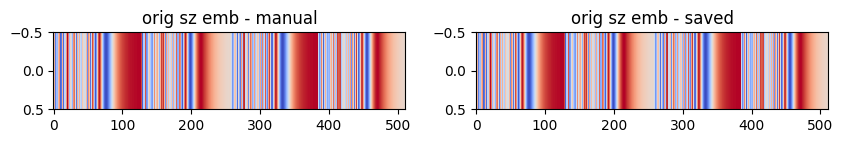

In [122]:
visually_compare_1d(my_time_embeds[0][:512], emb_l_orig_sz, ('orig sz emb - manual','orig sz emb - saved'))

In [46]:
my_time_embeds[0][:512][:10]==emb_l_orig_sz[:10]

tensor([ True, False, False,  True, False, False, False,  True, False, False])

In [54]:
print(my_time_embeds[0][:512][:10])
print(emb_l_orig_sz[:10])

tensor([ 0.1191, -0.0330,  0.5759, -1.0000, -0.5341, -0.2881, -0.7052,  0.6554, -0.0907,  0.9736])
tensor([ 0.1191, -0.0331,  0.5759, -1.0000, -0.5342, -0.2881, -0.7051,  0.6554, -0.0908,  0.9736])


In [52]:
allclose(my_time_embeds[0][:512], emb_l_orig_sz, atol=1e-4)

True

**A:** They are equal up to 1e-4. So the difference is operational randomness.

Let's now compare local additional time embs to cloud additional time embs

**Q:** Are the additional time emebds identical for local and cloud?

In [63]:
def equal(x,y,atol=1e-4): return allclose(x,y,atol=atol)

In [81]:
equal(emb_l_orig_sz, emb_c_orig_sz[0]), equal(emb_l_crop, emb_c_crop[0]), equal(emb_l_tgt_sz, emb_c_tgt_sz[0])

(True, True, True)

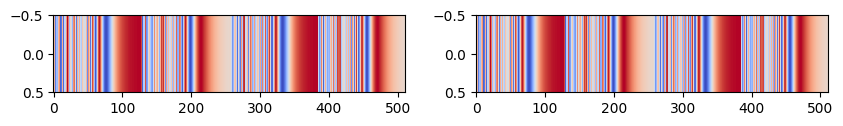

In [109]:
visually_compare_1d(emb_l_orig_sz, emb_c_orig_sz[0])

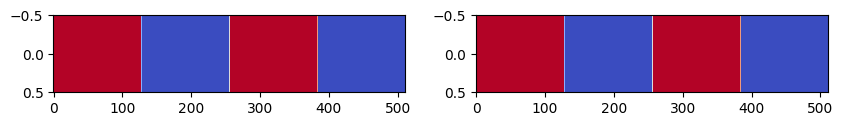

In [110]:
visually_compare_1d(emb_l_crop, emb_c_crop[0])

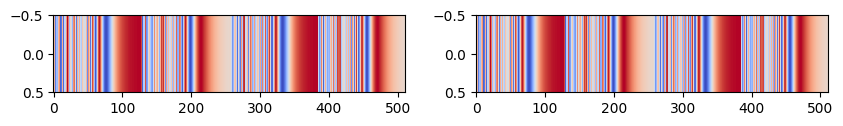

In [111]:
visually_compare_1d(emb_l_tgt_sz, emb_c_tgt_sz[0])

**A:** Yey, they're equal up to 1e-4, which can well be operational randomess.

___

What about the text-part of additional time embeddings?

In [100]:
emb_l_text_embeds = emb_l_add_embeds[0][:1280]

In [101]:
txt_l = emb_l_text_embeds
txt_c = emb_c_text[0]

In [102]:
assert txt_l.shape==txt_c.shape

In [103]:
equal(txt_c, txt_l)

False

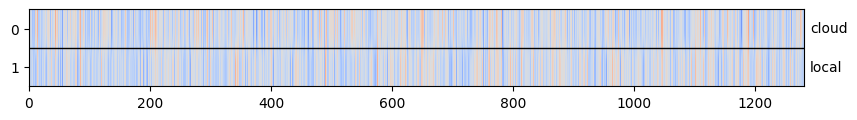

In [123]:
visually_compare_1d(txt_c, txt_l, ('cloud','local'), joint=True)

In [124]:
txt_c[:10], txt_l[:10]

(tensor([-0.8291,  0.9678, -0.6641,  0.9736, -0.6597, -0.5054, -1.7686, -0.2365, -1.1006, -1.0020]),
 tensor([-0.5941, -0.3394, -0.4070,  0.5561, -1.0181,  0.1388,  0.2324, -1.2147, -0.7827, -0.1039]))

They are different.

Maybe I re-create the cloud `text_embedder_2` locally. Then I could compare intermediate results easier.

**To be continued in `Compare intermediate results -- 3.ipynb`**